In [1]:
%load_ext autoreload
%autoreload 2

from diffusers import ControlNetModel
import torch

In [3]:
from text3d2video.generative_rendering import GenerativeRenderingPipeline
from text3d2video.pipelines.sd_pipeline import SDPipeline

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

device = torch.device("cuda")
dtype = torch.float16

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

# pipe = GenerativeRenderingPipeline.from_pretrained(
#     sd_repo, controlnet=controlnet, torch_dtype=dtype
# ).to(device)

pipe = SDPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

Keyword arguments {'controlnet': ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
   

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


100%|██████████| 51/51 [00:13<00:00,  3.86it/s]


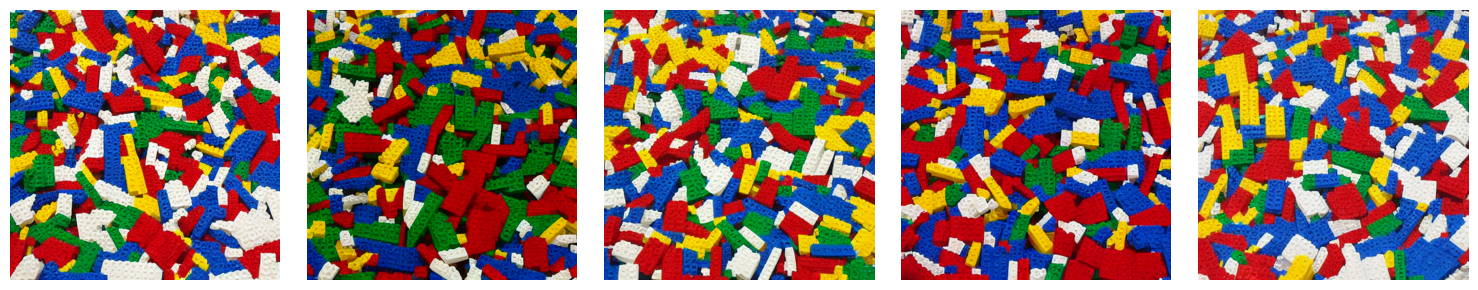

In [67]:
from text3d2video.generative_rendering_attn import GenerativeRenderingAttn
from text3d2video.ipython_utils import display_ims

attn_processor = GenerativeRenderingAttn(normal_pipe.unet, 2)
attn_processor.do_pre_attn_injection = False
attn_processor.do_post_attn_injection = False
attn_processor.do_extended_attention = False
attn_processor.do_cross_frame_attn = False
normal_pipe.unet.set_attn_processor(attn_processor)

generator = torch.Generator(device=device)
generator.manual_seed(0)

ims = normal_pipe(["Lego Minifigure"] * 5, generator=generator, num_inference_steps=50)
display_ims(ims, scale=3)

In [6]:
from text3d2video.generative_rendering_attn import GenerativeRenderingAttn
from text3d2video.sd_feature_extraction import SAFeatureExtractor, get_module_from_path

latents = pipe.prepare_latents(2, 512)

module_paths = [
    "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    # "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    # "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    # "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    # "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    # "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    # "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
    # "mid_block.attentions.0.transformer_blocks.0.attn1",
]

extractor = SAFeatureExtractor()
for attn_path in module_paths:
    attn = get_module_from_path(pipe.unet, attn_path)
    extractor.add_attn_hooks(attn, attn_path)

cond_embeddings, uncond_embeddings = pipe.encode_prompt(["Deadpool"]*2)
text_embeddings = torch.cat([cond_embeddings, uncond_embeddings], dim=1)
t = 0

attn_processor = GenerativeRenderingAttn(pipe.unet, 1)
attn_processor.do_pre_attn_injection = False
attn_processor.do_post_attn_injection = False
attn_processor.do_extended_attention = True
pipe.unet.set_attn_processor(attn_processor)

with torch.no_grad():

    pipe.unet(
        latents,
        t,
        encoder_hidden_states=text_embeddings,
    )

In [12]:
extractor.saved_outputs

for module_path, features in extractor.saved_outputs.items():
    # aggregate them in texture
    pass
    
